In [50]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [51]:
import numpy as np
import pandas as pd

In [52]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [53]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [54]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [55]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [56]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [57]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [58]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

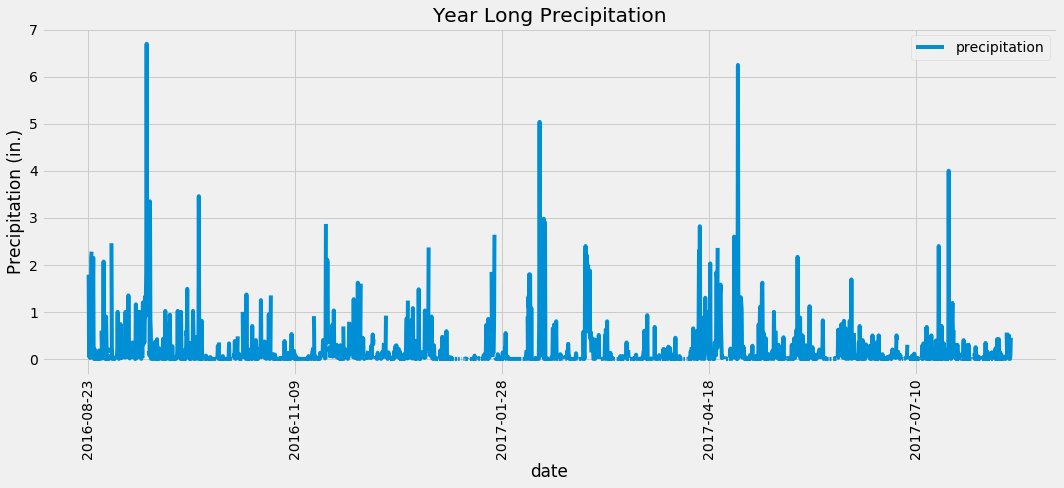

In [61]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
maxDate = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(5).all()
tempValMaxDate = list(np.ravel(maxDate))[0]
tempValMaxDate = dt.datetime.strptime(tempValMaxDate, '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
yearAgo = tempValMaxDate - dt.timedelta(weeks=52.2)

# Perform a query to retrieve the data and precipitation scores
rainQuery = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= yearAgo).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rainQuery, columns = ['date', 'precipitation'])

#rain_df = pd.DataFrame(rainQuery)
rain_df.set_index('date', inplace=True)

# Sort the dataframe by date
rain_df = rain_df.sort_index(ascending = True)

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (15, 7))
rain_df.plot(ax = ax, x_compat = True, rot=90)
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Year Long Precipitation")

plt.savefig('Images/precipitation.png')
plt.tight_layout()
plt.show()

In [62]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [63]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).count()
print(f"There are {stations} stations available.")

There are 9 stations available.


In [75]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())

print(stations)

#Most Active Station
stationID = stations[0][0]
print(f"\n The most active staion {stationID}.")

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]

 The most active staion USC00519281.


In [84]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temperature = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                            filter(Measurement.station == stationID).all()
temperature

[(54.0, 85.0, 71.66378066378067)]

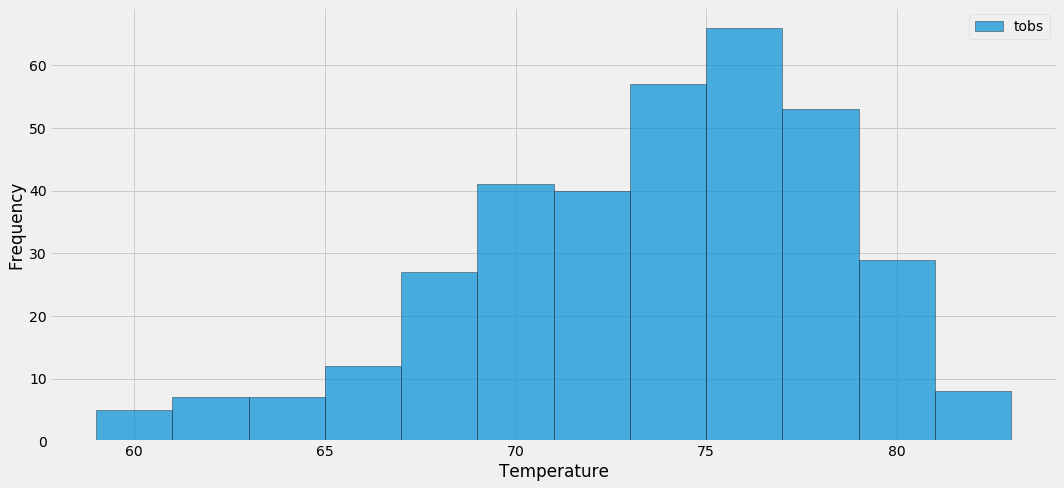

In [95]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempObservation = session.query(Measurement.date, Measurement.tobs).\
                            filter(Measurement.station == stationID).\
                            filter(func.strftime("%Y-%m-%d", Measurement.date) >= yearAgo).all()


tempObservation_df = pd.DataFrame(tempObservation)

fig, ax = plt.subplots(figsize = (15,7))
tempObservation_df.plot.hist(bins = 12, ax = ax, alpha=.7, edgecolor='black')
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')


#plt.savefig("Images/yearlyHist.png")
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
